In [70]:
import struct
import zlib

import cv2
import matplotlib.pyplot as plt
import numpy
import numpy as np
from matplotlib import pyplot
from scipy.fftpack import dct
from scipy.fftpack import idct

# Zadanie 1

In [71]:
plt.rcParams['figure.figsize'] = [10, 10]
#
# PPM file header
#
ppm_ascii_header = 'P3 400 400 255 '  # TODO: implement
ppm_binary_header = 'P6 400 400 255 '  # TODO: implement

#
# Image data
#
image = numpy.array([255, 0, 0] * 400 * 400, dtype=numpy.uint8)  # TODO: implement

#
# Save the PPM image as an ASCII file
#
with open('./lab4-ascii.ppm', 'w') as fh:
    fh.write(ppm_ascii_header)
    image.tofile(fh, sep=' ')
    fh.write('\n')

#
# Save the PPM image as a binary file
#
with open('./lab4-binary.ppm', 'wb') as fh:
    fh.write(bytearray(ppm_binary_header, 'ascii'))
    image.tofile(fh)

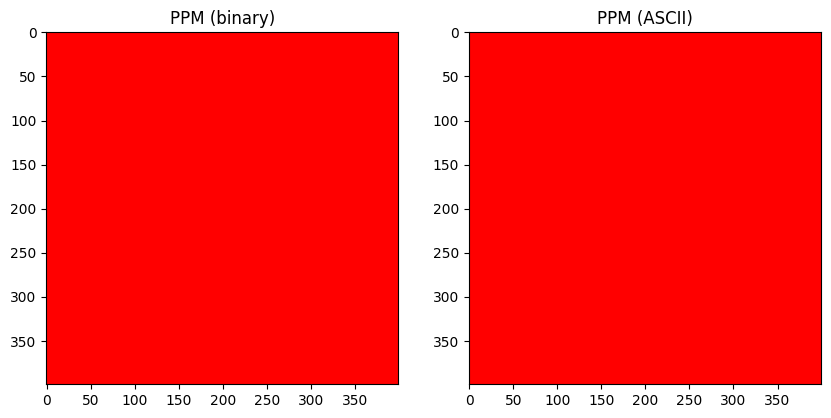

In [72]:
fig, ax = plt.subplots(1, 2)
binary_file = cv2.imread('lab4-binary.ppm')
ascii_file = cv2.imread('lab4-ascii.ppm')

ax[0].imshow(cv2.cvtColor(binary_file, cv2.COLOR_BGR2RGB))
ax[0].set_title('PPM (binary)')
ax[1].imshow(cv2.cvtColor(ascii_file, cv2.COLOR_BGR2RGB))
ax[1].set_title('PPM (ASCII)')
plt.show()

# Zadanie 2

In [73]:
def rgb_range_0_255():
    return np.linspace(0, 255, 256, dtype=np.uint8)


def rgb_range_255_0():
    return np.linspace(255, 0, 256, dtype=np.uint8)


rainbow_image = np.array([
    np.array([[0, 0, x] for x in rgb_range_0_255()]),
    np.array([[0, x, 255] for x in rgb_range_0_255()]),
    np.array([[0, 255, x] for x in rgb_range_255_0()]),
    np.array([[x, 255, 0] for x in rgb_range_0_255()]),
    np.array([[255, x, 0] for x in rgb_range_255_0()]),
    np.array([[255, 0, x] for x in rgb_range_0_255()]),
    np.array([[255, x, 255] for x in rgb_range_0_255()]),
], dtype=np.uint8).flatten()

height = 100
ppm_header = f'P3 {len(rainbow_image) // 3} {height} 255 '

rainbow_image = np.tile(rainbow_image, height)

with open('lab4-rainbow.ppm', 'w') as file:
    file.write(ppm_header)
    rainbow_image.tofile(file, sep=' ')
    file.write('\n')

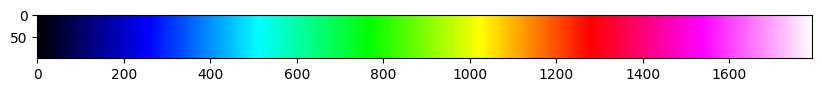

In [74]:
#
# Display image
#

binary_file = cv2.imread('lab4-rainbow.ppm')
pyplot.imshow(cv2.cvtColor(binary_file, cv2.COLOR_BGR2RGB))

# Zadanie 3

In [75]:

def write_to_png(_image, filename):
    h = len(_image)
    w = len(_image[0])

    png_file_signature = b'\x89PNG\r\n\x1a\n'

    header_id = b'IHDR'
    header_content = struct.pack('!IIBBBBB', w, h, 8, 2, 0, 0, 0)
    header_size = struct.pack('!I', len(header_content))
    header_crc = struct.pack('!I', zlib.crc32(header_id + header_content))
    png_file_header = header_size + header_id + header_content + header_crc

    data_id = b'IDAT'
    data_content = zlib.compress(b''.join([b'\x00' + bytes(row) for row in _image]))
    data_size = struct.pack('!I', len(data_content))
    data_crc = struct.pack('!I', zlib.crc32(data_id + data_content))
    png_file_data = data_size + data_id + data_content + data_crc

    end_id = b'IEND'
    end_content = b''
    end_size = struct.pack('!I', len(end_content))
    end_crc = struct.pack('!I', zlib.crc32(end_id + end_content))
    png_file_end = end_size + end_id + end_content + end_crc

    with open(filename, 'wb') as _fh:
        _fh.write(png_file_signature)
        _fh.write(png_file_header)
        _fh.write(png_file_data)
        _fh.write(png_file_end)

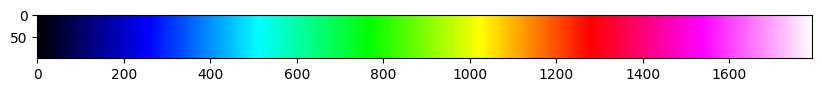

In [76]:
image = rainbow_image.copy().reshape(height, 1792, 3)

write_to_png(image, 'lab4.png')
binary_file = cv2.imread('lab4.png')
pyplot.imshow(cv2.cvtColor(binary_file, cv2.COLOR_BGR2RGB))

# Funkcje pomocnicze do zadań 4 i 5

In [77]:
#
# 2d Discrete Cosinus Transform
#
def dct2(array):
    return dct(dct(array, axis=0, norm='ortho'), axis=1, norm='ortho')


def idct2(array):
    return idct(idct(array, axis=0, norm='ortho'), axis=1, norm='ortho')


#
# Calculate quantisation matrices
#
# Based on: https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/jpegUpToQuant.html
#           #step-3-and-4-discrete-cosinus-transform-and-quantisation
#
_QY = numpy.array([[16, 11, 10, 16, 24, 40, 51, 61],
                   [12, 12, 14, 19, 26, 48, 60, 55],
                   [14, 13, 16, 24, 40, 57, 69, 56],
                   [14, 17, 22, 29, 51, 87, 80, 62],
                   [18, 22, 37, 56, 68, 109, 103, 77],
                   [24, 35, 55, 64, 81, 104, 113, 92],
                   [49, 64, 78, 87, 103, 121, 120, 101],
                   [72, 92, 95, 98, 112, 100, 103, 99]])

_QC = numpy.array([[17, 18, 24, 47, 99, 99, 99, 99],
                   [18, 21, 26, 66, 99, 99, 99, 99],
                   [24, 26, 56, 99, 99, 99, 99, 99],
                   [47, 66, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99]])


def _scale(QF):
    if QF < 50 and QF >= 1:
        scale = numpy.floor(5000 / QF)
    elif QF < 100:
        scale = 200 - 2 * QF
    else:
        raise ValueError('Quality Factor must be in the range [1..99]')

    scale = scale / 100.0
    return scale


def QY(QF=85):
    return _QY * _scale(QF)


def QC(QF=85):
    return _QC * _scale(QF)


def divide_8x8(array):
    new_h = array.shape[0] // 8
    new_w = array.shape[1] // 8
    blocks = np.zeros((new_h, new_w, 8, 8))
    for i in range(new_h):
        for j in range(new_w):
            blocks[i, j, :, :] = array[i*8:(i+1)*8, j*8:(j+1)*8]
    return blocks
    
def merge_8x8(array):
    new_h = array.shape[0] * 8
    new_w = array.shape[1] * 8
    merged = np.zeros((new_h, new_w))
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            merged[i*8:(i+1)*8, j*8:(j+1)*8] = array[i, j, :, :]
    return merged

def zig_zag(block):
    flat = []
    w, h = len(block), len(block[0])
    for i in range(w + h - 1):
        if i % 2 == 0:
            row = min(i, w - 1)
            col = max(0, i - w + 1)
            while row >= 0 and col < h:
                flat.append(block[row][col])
                row -= 1
                col += 1
        else:
            row = max(i, h-1)
            col = max(0, i - h + 1)
            while col >= 0 and row < w:
                flat.append(block[row][col])
                row += 1
                col -= 1
    return np.array(flat, np.int32)
            

# Zadania 4 i 5

In [78]:
def jpeg_conversion(src_filename, dest_filename, compression_rate, QF=85):
    img = cv2.imread(src_filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, c = img.shape
    original_w = w
    original_h = h
    needs_resize = False
    if w % (compression_rate * 8) != 0:
        w -= w % (compression_rate * 8)
        needs_resize = True
    
    if h % (compression_rate * 8) != 0:
        h -= h % (compression_rate * 8)
        needs_resize = True
    
    if needs_resize:
        img = cv2.resize(img, (w, h))
        h, w, c = img.shape
    
    # 1. Convert RGB to YCbCr
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    
    # 2. Downsampling on Cb and Cr channels
    y = img[:, :, 0]
    cr = img[:, :, 1]
    if compression_rate != 1:
        cr = cv2.pyrDown(cr)
        if compression_rate == 4:
            cr = cv2.pyrDown(cr)
    
    cb = img[:, :, 2]
    if compression_rate != 1:
        cb = cv2.pyrDown(cb)
        if compression_rate == 4:
            cb = cv2.pyrDown(cb)
            
    # 3. Produce 8x8 blocks
    blocks_y = divide_8x8(y)
    blocks_cb = divide_8x8(cb)
    blocks_cr = divide_8x8(cr)
    
    # # 4. Calculate DCT on each block
    blocks_y = np.array([[dct2(block) for block in row] for row in blocks_y])
    blocks_cb = np.array([[dct2(block) for block in row] for row in blocks_cb])
    blocks_cr = np.array([[dct2(block) for block in row] for row in blocks_cr])
    
    # 5. Divide each block by quantisation matrix
    # 6. Round values in each block to integers
    
    blocks_y = np.array([[block / QY(QF) for block in row] for row in blocks_y], dtype=np.int32)
    blocks_cb = np.array([[block / QC(QF) for block in row] for row in blocks_cb], dtype=np.int32)
    blocks_cr = np.array([[block / QC(QF) for block in row] for row in blocks_cr], dtype=np.int32)
    
    # 7. Zig Zag
    # TODO: implement (zad. 4)
    flat_y = np.array([[zig_zag(block) for block in row] for row in blocks_y], dtype=np.int32)
    flat_cb = np.array([[zig_zag(block) for block in row] for row in blocks_cb], dtype=np.int32)
    flat_cr = np.array([[zig_zag(block) for block in row] for row in blocks_cr], dtype=np.int32)
    
    # 8. Flatten, concatenate, compress and calculate the size -- how many bytes?
    # TODO: implement (zad. 4)
    bytes_image = zlib.compress(b'' + bytes(flat_y.flatten()) + bytes(flat_cb.flatten()) + bytes(flat_cr.flatten()))
    size = len(bytes_image)
    
    # 7'. Undo Zig Zag
    
    # 5'. Reverse division by quantisation matrix -- multiply
    blocks_y = np.array([[block * QY(QF) for block in row] for row in blocks_y])
    blocks_cb = np.array([[block * QC(QF) for block in row] for row in blocks_cb])
    blocks_cr = np.array([[block * QC(QF) for block in row] for row in blocks_cr])
    
    # 4'. Reverse DCT
    blocks_y = np.array([[idct2(block) for block in row] for row in blocks_y])
    blocks_cb = np.array([[idct2(block) for block in row] for row in blocks_cb])
    blocks_cr = np.array([[idct2(block) for block in row] for row in blocks_cr])
    
    # 3'. Combine 8x8 blocks to original image
    y = merge_8x8(blocks_y)
    cb = merge_8x8(blocks_cb)
    cr = merge_8x8(blocks_cr)
    
    # 2'. Upsampling on Cb and Cr channels
    if compression_rate != 1:
        cb = cv2.pyrUp(cb)
        cr = cv2.pyrUp(cr)
        if compression_rate == 4:
            cb = cv2.pyrUp(cb)
            cr = cv2.pyrUp(cr)
    
    
    # 1'. Convert YCbCr to RGB
    encoded_image = np.empty((h, w, 3), np.uint8)
    encoded_image[:, :, 0] = y
    encoded_image[:, :, 1] = cr
    encoded_image[:, :, 2] = cb
    encoded_image = cv2.cvtColor(encoded_image, cv2.COLOR_YCR_CB2RGB)
    if needs_resize:
        encoded_image = cv2.resize(encoded_image, (original_w, original_h))
    
    # 0'. Save the decoded image -- as PPM or PNG
    write_to_png(encoded_image, dest_filename)
    return size
    
size_1 = jpeg_conversion('lab4.png', 'lab4_jpeg_1.png', 1)
size_2 = jpeg_conversion('lab4.png', 'lab4_jpeg_2.png', 2)
size_3 = jpeg_conversion('lab4.png', 'lab4_jpeg_4.png', 4)
print(size_1, size_2, size_3)

12187 6920 5001


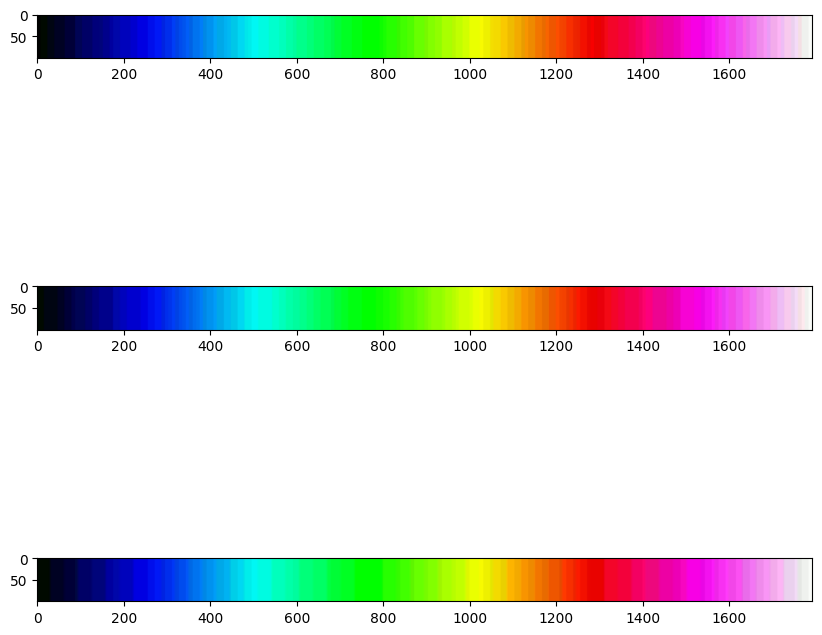

In [79]:
#
# Display image
#
fif, ax = plt.subplots(3)
ax[0].imshow(cv2.cvtColor(cv2.imread('lab4_jpeg_1.png'), cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(cv2.imread('lab4_jpeg_2.png'), cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(cv2.imread('lab4_jpeg_4.png'), cv2.COLOR_BGR2RGB))

# Obserwacje z zadań 4 i 5